In [1]:
# Importing relevant Python libraries
import pandas
import requests
import re
import json
from queue import Queue
from threading import Thread
import numpy

%matplotlib inline

In [2]:
# Suppressing InsecureRequestWarning
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

In [3]:
# Reading the extracted URL's
url_df = pandas.read_csv("../data/extracted_urls.csv")
url_df.head()

,tweet_id,tweet_url,created_at,url,resolved
0,9.558460e+17,https://twitter.com/kpaxnews/status/9558459703...,2018-01-23 16:53:32,http://www.kpax.com/story/37329938/kentucky-sc...,http://www.kpax.com/story/37329938/kentucky-sc...
1,9.558460e+17,https://twitter.com/KAJNews/status/95584596919...,2018-01-23 16:53:32,http://www.kpax.com/story/37329938/kentucky-sc...,http://www.kpax.com/story/37329938/kentucky-sc...
2,9.558460e+17,https://twitter.com/kwanzer/status/95584595940...,2018-01-23 16:53:30,https://www.nbcnews.com/news/us-news/one-dead-...,https://www.nbcnews.com/news/us-news/one-dead-...
3,9.558459e+17,https://twitter.com/_moribund_/status/95584593...,2018-01-23 16:53:23,http://cnn.it/2BpIXhK,http://www.cnn.com/2018/01/23/us/kentucky-high...
4,9.558459e+17,https://twitter.com/rollin_oliver/status/95584...,2018-01-23 16:53:19,http://abcn.ws/2BoEmMG,http://abcnews.go.com/US/wounded-shooting-kent...


In [4]:
# Resolves a shortened URL to its final form
def resolve_url(url):
    try:
        response = requests.head(url, allow_redirects = True, verify = False, timeout = 10)
    except Exception:
        return None
    return response.url

def work(q, resolved):
    while True:
        url = q.get()
        resolved[url] = resolve_url(url)
        q.task_done()

# Expands a list of shortened URLs to the final URLs
def resolve_urls(urls, n_threads = 5):
    resolved = {}
    
    urls = list(set(urls)) # Remove duplicate URLs
    q = Queue(maxsize=0)
    for url in urls:
        q.put(url)

    for i in range(n_threads):
      worker = Thread(target=work, args=(q, resolved))
      worker.setDaemon(True)
      worker.start()
    
    q.join()
    
    return resolved

In [5]:
# Resolving the URLs within the dataframe
if "resolved" not in url_df.columns:
    resolved = resolve_urls(url_df.url, n_threads = 5)
    url_df["resolved"] = url_df.url.apply(lambda X: resolved[X])
url_df.head()

,tweet_id,tweet_url,created_at,url,resolved
0,9.558460e+17,https://twitter.com/kpaxnews/status/9558459703...,2018-01-23 16:53:32,http://www.kpax.com/story/37329938/kentucky-sc...,http://www.kpax.com/story/37329938/kentucky-sc...
1,9.558460e+17,https://twitter.com/KAJNews/status/95584596919...,2018-01-23 16:53:32,http://www.kpax.com/story/37329938/kentucky-sc...,http://www.kpax.com/story/37329938/kentucky-sc...
2,9.558460e+17,https://twitter.com/kwanzer/status/95584595940...,2018-01-23 16:53:30,https://www.nbcnews.com/news/us-news/one-dead-...,https://www.nbcnews.com/news/us-news/one-dead-...
3,9.558459e+17,https://twitter.com/_moribund_/status/95584593...,2018-01-23 16:53:23,http://cnn.it/2BpIXhK,http://www.cnn.com/2018/01/23/us/kentucky-high...
4,9.558459e+17,https://twitter.com/rollin_oliver/status/95584...,2018-01-23 16:53:19,http://abcn.ws/2BoEmMG,http://abcnews.go.com/US/wounded-shooting-kent...


In [6]:
# Updating the extracted links with resolved URLs
url_df.to_csv("../data/extracted_urls.csv", index = False)

In [7]:
# Finding information on the domain for each resolved URL

url_df.resolved = url_df.resolved.fillna("")

# Extracting the domain from the URL
domain_re = re.compile("http[s]*://([^/]+)")
url_df["resolved_domain"] = url_df.resolved.apply(lambda X: domain_re.search(X).group(1) if X != "" else "")

# Removing leading www.
www_re = re.compile("^www\.")
url_df["resolved_domain"] = url_df["resolved_domain"].apply(lambda X: www_re.sub("", X) if X != "" else "")

url_df.head()

,tweet_id,tweet_url,created_at,url,resolved,resolved_domain
0,9.558460e+17,https://twitter.com/kpaxnews/status/9558459703...,2018-01-23 16:53:32,http://www.kpax.com/story/37329938/kentucky-sc...,http://www.kpax.com/story/37329938/kentucky-sc...,kpax.com
1,9.558460e+17,https://twitter.com/KAJNews/status/95584596919...,2018-01-23 16:53:32,http://www.kpax.com/story/37329938/kentucky-sc...,http://www.kpax.com/story/37329938/kentucky-sc...,kpax.com
2,9.558460e+17,https://twitter.com/kwanzer/status/95584595940...,2018-01-23 16:53:30,https://www.nbcnews.com/news/us-news/one-dead-...,https://www.nbcnews.com/news/us-news/one-dead-...,nbcnews.com
3,9.558459e+17,https://twitter.com/_moribund_/status/95584593...,2018-01-23 16:53:23,http://cnn.it/2BpIXhK,http://www.cnn.com/2018/01/23/us/kentucky-high...,cnn.com
4,9.558459e+17,https://twitter.com/rollin_oliver/status/95584...,2018-01-23 16:53:19,http://abcn.ws/2BoEmMG,http://abcnews.go.com/US/wounded-shooting-kent...,abcnews.go.com


In [8]:
print("Number of unique domains: %d" % len(url_df.resolved_domain.unique()))

Number of unique domains: 982


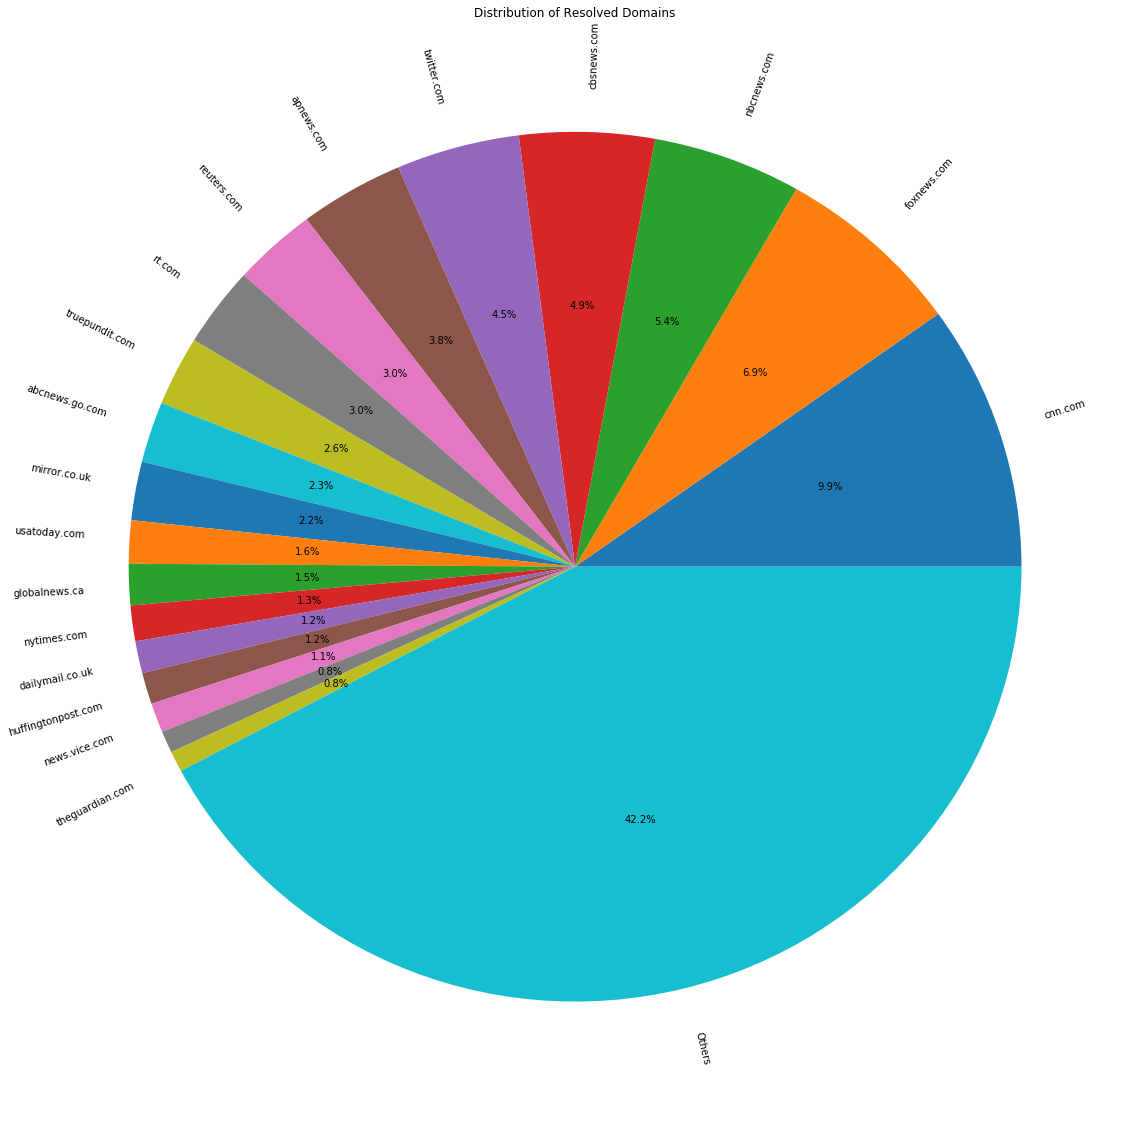

In [15]:
# Creating a visualization of domain distribution
series = url_df.resolved_domain.value_counts()
series2 = series.head(19)
if len(series) > 19:
    series2['Others'.format(len(series) - 19)] = sum(series[19:])
series2.plot.pie(figsize=(20, 20), autopct='%1.1f%%', label = "", title = "Distribution of Resolved Domains", rotatelabels = True)